In [1]:
# import ModuleFinance as fi
from ModuleFinance import *

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json

## MarketData

In [ ]:
def NNS(param: list, t: float) -> float:
    if t == 0:
        raise ValueError("Maturity must be non-zero")

    B0, B1, B2, B3, λ, κ = param
    F1 = (1 - np.exp(-t/λ)) / (t/λ)
    F2 = ((1 - np.exp(-t/λ)) / (t/λ)) - np.exp(-t/λ)
    F3 = ((1 - np.exp(-t/κ)) / (t/κ)) - np.exp(-t/κ)
    Resultat = B0 + B1*F1 + B2*F2 + B3*F3
    return Resultat


## SimuMC

### Vieux Code

In [2]:
def Standard(self) -> pd.DataFrame:
    #Constante
    drift = ((self.r-self.q) - (self.Vol**2)/2)*(1/self.N)
    diffusion = self.Vol*np.sqrt(1/self.N)
    Longeur = int((self.N * self.T) + 1)
    #Création Array
    df = pd.DataFrame(np.zeros((self.M, Longeur), dtype=float))
    Z = np.random.standard_normal((Longeur, self.M))
    df[0] = float(self.S)
    for i in range(1,Longeur):
        df[i] = df[i-1] * np.exp(drift + Z[i-1]*diffusion)
    return df

def RV_Correl(self) -> pd.DataFrame:
    drift = ((self.r-self.q) - (self.Vol**2)/2)*(1/self.N)
    diffusion = self.Vol*np.sqrt(1/self.N)
    Longeur = int((self.N * self.T) + 1)
    df = pd.DataFrame(np.zeros((self.N, Longeur), dtype=float))
    df_Correl = pd.DataFrame(np.zeros((self.N, Longeur), dtype=float))
    df[0] = float(self.S)
    df_Correl[0] = float(self.S)
    for i in range(1,Longeur):
        Z = np.random.standard_normal(self.N)
        df[i] = df[i-1] * np.exp(drift + Z*diffusion)
        df_Correl[i] = df_Correl[i-1] * np.exp(drift - Z*diffusion)
    return np.dstack((df, df_Correl))

def RV_CV(self) -> np.ndarray:
    #ne fonctionne que pour les vanilles car j'ai besoin du delta donc inutile
    pass

def Pseudo(self) -> np.ndarray:
    #besoin d'autres lybrairies + pas utile vu le nombre de simu que je fais donc inutile
    pass

### Test Code

In [2]:
Udl = MarketData(Spot=100, Vol=0.2, Taux=0.05, Div=0.02)
ParamMC = MonteCarlo(Udl,1,252,500_000)
df_MC = pd.DataFrame(ParamMC.Stantard())

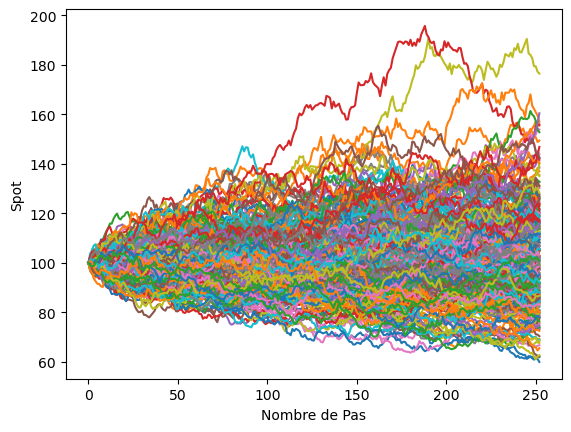

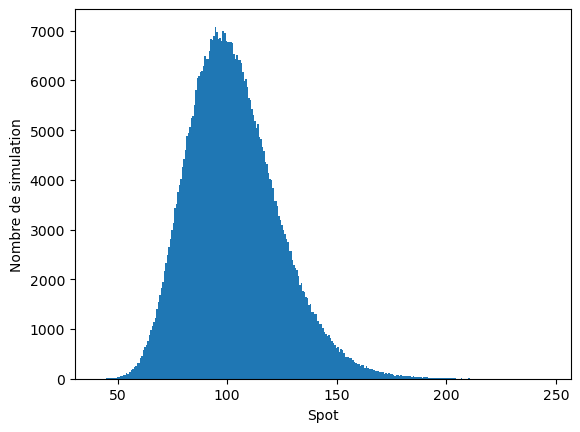

In [3]:
for i in range(0,len(df_MC.columns)):  
    plt.plot(df_MC.iloc[i])
plt.xlabel("Nombre de Pas")
plt.ylabel("Spot")
plt.show()
plt.hist(df_MC[252], bins='auto')
plt.ylabel("Nombre de simulation")
plt.xlabel("Spot")
plt.show()

In [4]:
test = ParamMC.RV_Correl()

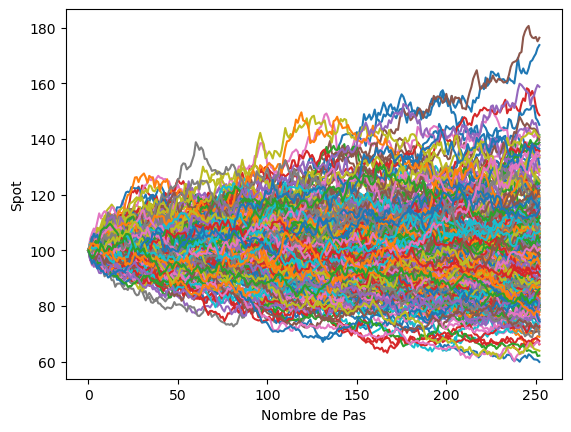

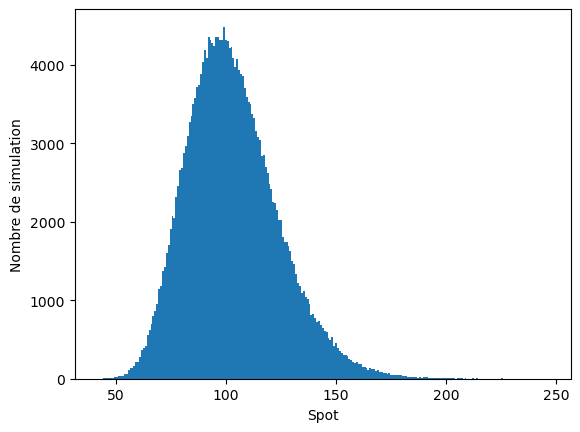

In [5]:
df1 = pd.DataFrame(test[:,:,0])
for i in range(0,len(df1.columns)):  
    plt.plot(df1.iloc[i])
plt.xlabel("Nombre de Pas")
plt.ylabel("Spot")
plt.show()
plt.hist(df1[252], bins='auto')
plt.ylabel("Nombre de simulation")
plt.xlabel("Spot")
plt.show()

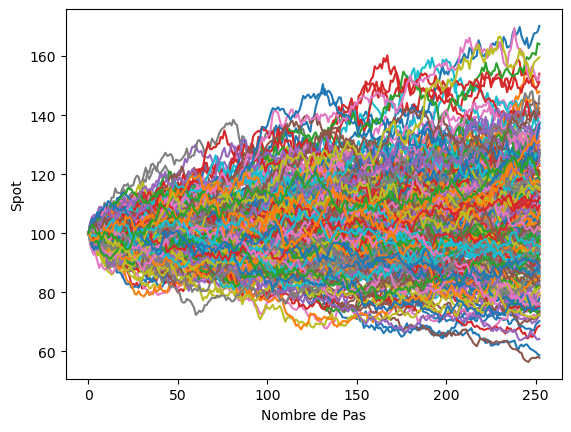

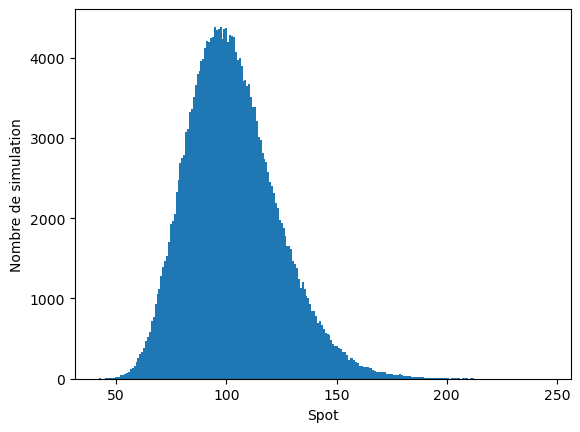

In [6]:
df2 = pd.DataFrame(test[:,:,1])
for i in range(0,len(df2.columns)):  
    plt.plot(df2.iloc[i])
plt.xlabel("Nombre de Pas")
plt.ylabel("Spot")
plt.show()
plt.hist(df2[252], bins='auto')
plt.ylabel("Nombre de simulation")
plt.xlabel("Spot")
plt.show()

In [7]:
std1 = []
std2 = []
for i in range(10):
    temp = ParamMC.RV_Correl()
    df1 = pd.DataFrame(temp[:,:,0])
    df2 = pd.DataFrame(temp[:,:,1])
    std1.append(df1[252].std())
    std2.append(df2[252].std())
print(np.array(std1).mean())
print(np.array(std2).mean())

20.807362260427368
20.816011402546557


## Autocall

In [ ]:
@timer
def prix(self, simu: int=262143, SE = False) -> tuple[float, float]|float:
    #initialisation
    updated = self.update()
    
    if self.PrixMC is None or updated:
        Date_Obs = self.Date_Obs
        Liste_Payoff = []
        Coupon = self.Coupon * (self.Obs/12)
        if self.MC is None or updated:
        self.MC = MonteCarlo(self.MD, self.T, 12/self.Obs, simu).Stantard()
            # self.MC = MonteCarlo(self.MD, self.T, 252, simu).Stantard()

        for simulation in self.MC:
            self.Recall = False
            Gain = 0
            Perte = 0
            for i, date in enumerate(Date_Obs[1:], start=1):
                if not self.Recall:
                    spot = simulation[i]
                    if spot > self.B_Recall:
                        self.Recall = True
                    if spot > self.B_Coupon:
                        Gain += Coupon * self.Nom
                    if i == (len(Date_Obs)-1) or self.Recall:
                        if spot < self.B_PDI:
                            Perte = -self.Nom * (1 - (spot/self.K))
                        # Taux = self.MD.get_rate_curve(i) #a set up 
                        Payoff = (Gain + Perte + self.Nom) * np.exp(-self.MD.Taux * (i * (self.Obs/12)))
                        Liste_Payoff.append(Payoff)
        Liste_Payoff = np.array(Liste_Payoff)   
        self.PrixMC = Liste_Payoff.mean()
        Std = Liste_Payoff.std()
        self.SE = (Std) / (np.sqrt(simu))
    if SE:
        return self.PrixMC, self.SE
    else:
        return self.PrixMC



#-------------------------------------------------------------"MonteCarlo"-------------------------------------------------------------#
def price(self, simu: int=262143, SE = False) -> tuple[float, float]|float:
    #initialisation
    updated = self.update()
    
    if self.PrixMC is None or updated:
        Coupon = self.Coupon * (self.Obs/12)
        if self.MC is None or updated:
            self.MC = MonteCarlo(self.MD, self.T, 12/self.Obs, simu).Stantard()

        Array_Recall = np.where(self.MC>self.B_Recall, 1, 0)                                                
        Array_Recall[:, 0] = 0                                                                              #met un 0 pour 
        Temp_Recall = np.argmax(Array_Recall == 1, axis=1)                                                  #indique la position de mon premier 1.
        Date_Recall = np.where(Temp_Recall == 0, len(self.Date_Obs)-1, Temp_Recall)                         #me permet d'avoir l'index du premier 1 dans chaque ligne
        Array_Recall = np.where(np.arange(Array_Recall.shape[1]) > Date_Recall[:, np.newaxis], 0, 1)        #si qui me permet de fill de 0 ou de 1 (suivant le vrai,faux), une fois que je suis au dessus de l'index determiné dans la ligne du dessus
        Array_Coupon = np.where(self.MC>self.B_Coupon, Array_Recall*Coupon, 0)                              #permet de calculer mon coupon gagné
        Array_Coupon[:, 0] = 0
        Last = self.MC[np.arange(len(self.MC)), Date_Recall]                                                #permet de retourner le last spot
        Array_PDI = np.where(Last<self.B_PDI, self.Nom*((Last/self.K)-1), 0)

        Payoff_Coupon = np.sum(Array_Coupon*self.Nom, axis=1)
        # r = self.MD.get_rate_curve(Maturité)  A SET UP
        Discount_Factor = np.exp(-self.MD.Taux * (Date_Recall * (self.Obs/12)))
        
        Payoff = (Array_PDI + Payoff_Coupon + self.Nom) * Discount_Factor
        self.PrixMC = Payoff.mean()
        Std = Payoff.std()
        self.SE = (Std) / (np.sqrt(simu))
        if SE:
            return self.PrixMC, self.SE
        else:
            return self.PrixMC

def full_price(self, simu: int=262143, SE = False) -> tuple[float, float]|float:
    #initialisation
    updated = self.update()
    
    if self.PrixMC is None or updated:
        Coupon = self.Coupon * (self.Obs/12)
        if self.MC is None or updated:
            self.MC = MonteCarlo(self.MD, self.T, 252, simu).Stantard()

        
        Selected_MC = self.MC[:, range(0, self.MC.shape[1], int(252 * (self.Obs/12)))]
        Array_Recall = np.where(Selected_MC>self.B_Recall, 1, 0)
        Array_Recall[:, 0] = 0
        Temp_Recall = np.argmax(Array_Recall == 1, axis=1)
        Date_Recall = np.where(Temp_Recall == 0, len(self.Date_Obs)-1, Temp_Recall)
        Array_Recall = np.where(np.arange(Array_Recall.shape[1]) > Date_Recall[:, np.newaxis], 0, 1)
        Array_Coupon = np.where(Selected_MC>self.B_Coupon, Array_Recall*Coupon, 0)
        Array_Coupon[:, 0] = 0
        Last = Selected_MC[np.arange(len(Selected_MC)), Date_Recall]
        Array_PDI = np.where(Last<self.B_PDI, self.Nom*((Last/self.K)-1), 0)

        Payoff_Coupon = np.sum(Array_Coupon*self.Nom, axis=1)
        # r = self.MD.get_rate_curve(Maturité)  A SET UP
        Discount_Factor = np.exp(-self.MD.Taux * (Date_Recall * (self.Obs/12)))
        Payoff = (Array_PDI + Payoff_Coupon + self.Nom) * Discount_Factor
        
        self.PrixMC = Payoff.mean()
        Std = Payoff.std()
        self.SE = (Std) / (np.sqrt(simu))
        if SE:
            return self.PrixMC, self.SE
        else:
            return self.PrixMC

In [ ]:
#chatgpt method to calculate greeks.   
    def _calculate_price_change(self, attribute, quick=False):
        obj_up = self.copy()
        setattr(obj_up.MD, attribute, getattr(obj_up.MD, attribute) * 1.01)

        obj_down = self.copy()
        setattr(obj_down.MD, attribute, getattr(obj_down.MD, attribute) * 0.99)
        if quick:
            price_up = obj_up.quick_price()
            price_down = obj_down.quick_price()
        else:
            price_up = obj_up.price()
            price_down = obj_down.price()
        return (price_up - price_down) / 2

    def delta(self, quick=False):
        return self._calculate_price_change("Spot", 1.01, quick) * 100

    def vega(self, quick=False):
        return self._calculate_price_change("Vol", 1.01, quick) * 100

    def rho(self, quick=False):
        return self._calculate_price_change("Taux", 1.01, quick) * 10

    def theta(self, quick=False):
        if quick:
            error_message = "La fonction Theta n'a pas d'attribut quick car nous avons besoin de tous les pas de simulation de MC."
            raise ValueError(error_message)
        option_j1 = self.copy()
        option_j1.T -= 1 / 252
        price_change = self.price() - option_j1.price()
        return price_change

## Divers

In [ ]:
def fill_zero(Array: np.ndarray) -> np.ndarray:
    zero_mask = (Array == 0)
    first_zero_indices = np.argmax(zero_mask, axis=1) #permet de trouver le premier TRUE donc le premier 0
    mask_after_first_zero = np.arange(Array.shape[1]) > first_zero_indices[:, np.newaxis] #Si np.Arrage > first_zero alors ça return true et je dois mettre des 0
    Array = np.where(mask_after_first_zero, 0, Array)
    return Array

## Graphe Grecques

In [ ]:
#Graphe + Création JSON
Liste_Prix = []
fig, ax = plt.subplots(figsize=(15,8))
for t in ProgressBar(range(1,6)):
    Prix = []
    Produit = Autocall(MarketData=Udl, Coupon= 0.1, B_Recall=100, B_Coupon=100, B_PDI=60, K=100, Obs=12, T=t)
    for i in ProgressBar(range(200)):
        Udl.Spot = i
        Prix.append(Produit.price())
    ax.plot(range(200), Prix, linewidth=1, label=f"Maturité {round(t,2)} ans")
    with open(f"Data/Greeks_Mutli_Mat/Prix_Mat{t}.json", "w") as file:
        json.dump(Prix, file)
ax.legend()
plt.xlabel("Spot")
plt.ylabel("Prix")
plt.show()

In [ ]:
#Recup JSON
fig, ax = plt.subplots(figsize=(15,8))
for t in range(1,6):
    with open(f"Data/RV/Rho_Mat{t}.json", "r") as file:  #on peut faire plus simple en lisant tous le folder si je vais un folder par grecques
        Liste_Rho = json.load(file)
    ax.plot(range(200), Liste_Rho, linewidth=1, label=f"Maturité {round(t,2)} ans")
ax.legend()
plt.xlabel("Spot")
plt.ylabel("Delta")
plt.show()